In [1]:
%pip install --upgrade --quiet lifelines scikit-survival pandas scikit-learn seaborn

Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
df = pd.read_csv('data/learning_table.csv', sep=',')
df = df.drop(['target', 'date', 'obj_type', 'group'], axis=1)
print(df.head())
class_distribution = df['shifted_target'].value_counts()
print(class_distribution)

   coal_temp  temp_max  temp_mean  humidity_max  humidity_mean  precipitation  \
0       34.8      22.9  21.454167            90      84.875000            0.8   
1       31.2      22.7  22.220833            90      84.333333            0.9   
2       35.1      24.8  23.258333            91      81.041667            3.9   
3       33.2      27.0  24.983333            85      73.208333            0.0   
4       36.1      25.2  23.691667            72      58.708333            0.0   

      v_mean      v_max       p_mean   p_max  ...  sequence  shifted_target  \
0  12.891667  18.733333  1005.191667  1006.5  ...         1             0.0   
1  13.991667  19.979167  1008.475000  1010.6  ...         2             0.0   
2  14.400000  23.579167  1011.158333  1013.1  ...         1             0.0   
3  11.591667  16.400000  1013.237500  1013.7  ...         2             0.0   
4  22.812500  30.820833  1013.416667  1014.3  ...         3             0.0   

   coal_temp_rolling_mean  coal_temp_d

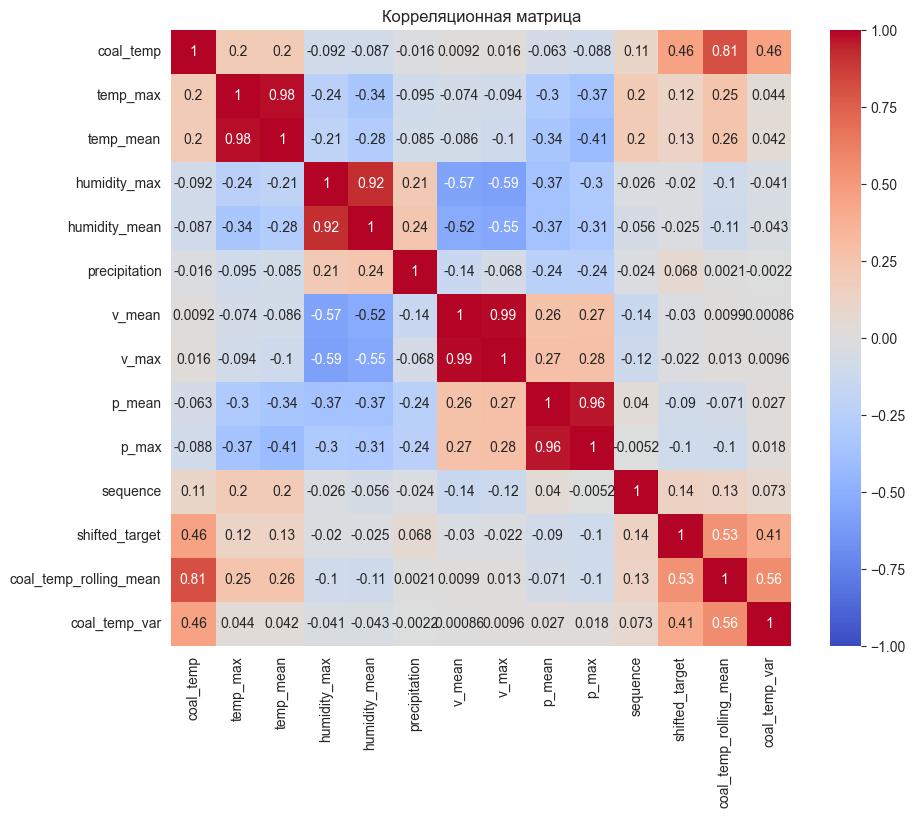

   coal_temp  temp_max  temp_mean  humidity_max  humidity_mean  precipitation  \
0       34.8      22.9  21.454167            90      84.875000            0.8   
1       31.2      22.7  22.220833            90      84.333333            0.9   
2       35.1      24.8  23.258333            91      81.041667            3.9   
3       33.2      27.0  24.983333            85      73.208333            0.0   
4       36.1      25.2  23.691667            72      58.708333            0.0   

      v_mean      v_max       p_mean   p_max  sequence  shifted_target  \
0  12.891667  18.733333  1005.191667  1006.5         1             0.0   
1  13.991667  19.979167  1008.475000  1010.6         2             0.0   
2  14.400000  23.579167  1011.158333  1013.1         1             0.0   
3  11.591667  16.400000  1013.237500  1013.7         2             0.0   
4  22.812500  30.820833  1013.416667  1014.3         3             0.0   

   coal_temp_rolling_mean  coal_temp_var  
0                   34.80

In [17]:
X = df.drop(columns=['summer', 'spring', 'autumn', 'coal_temp_deviation', 'month'
                     ,'coal_temp_p_mean', 'coal_temp_lag2d', 'coal_temp_lag1d', 'coal_temp_lag3d'])
correlation_matrix = X.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,  # Показать значения в ячейках
    cmap='coolwarm',  # Цветовая схема
    vmin=-1, vmax=1  # Диапазон значений
)
plt.title('Корреляционная матрица')
plt.show()

train_data, test_data = train_test_split(X, test_size=0.2, random_state=42)

print(X.head())

In [18]:
# Инициализация модели Cox
cph = CoxPHFitter(penalizer=0.1)  # penalizer помогает избежать переобучения

# Обучение модели
cph.fit(
    train_data,
    duration_col="sequence",  # Столбец времени
    event_col="shifted_target",     # Столбец индикатора события
    show_progress=True
)

Iteration 1: norm_delta = 6.37e-01, step_size = 0.9500, log_lik = -1008.42426, newton_decrement = 1.04e+02, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.84e-01, step_size = 0.9500, log_lik = -965.80613, newton_decrement = 3.08e+01, seconds_since_start = 0.0
Iteration 3: norm_delta = 5.62e-02, step_size = 0.9500, log_lik = -933.63125, newton_decrement = 1.15e+00, seconds_since_start = 0.0
Iteration 4: norm_delta = 3.81e-03, step_size = 1.0000, log_lik = -932.43567, newton_decrement = 5.16e-03, seconds_since_start = 0.0
Iteration 5: norm_delta = 1.91e-05, step_size = 1.0000, log_lik = -932.43049, newton_decrement = 1.21e-07, seconds_since_start = 0.0
Iteration 6: norm_delta = 4.51e-10, step_size = 1.0000, log_lik = -932.43049, newton_decrement = 6.77e-17, seconds_since_start = 0.0
Convergence success after 6 iterations.


<lifelines.CoxPHFitter: fitted with 1182 total observations, 1008 right-censored observations>

In [20]:
# Предсказание рисков (частичные риски)
test_data["predicted_risk"] = cph.predict_partial_hazard(test_data)

# Вычисление C-индекса
c_index = concordance_index(
    event_times=test_data["sequence"],
    predicted_scores=-test_data["predicted_risk"],  # Чем выше риск, тем раньше событие
    event_observed=test_data["shifted_target"]
)

print(f"C-индекс модели: {c_index:.3f}")

cph.print_summary()

C-индекс модели: 0.799


<lifelines.CoxPHFitter: fitted with 1182 total observations, 1008 right-censored observations>
             duration col = 'sequence'
                event col = 'shifted_target'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1182
number of events observed = 174
   partial log-likelihood = -932.43
         time fit was run = 2025-05-05 09:41:36 UTC

---
                        coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                               
coal_temp               0.00      1.00      0.00            0.00            0.00                1.00                1.00
temp_max                0.00      1.00      0.02           -0.04            0.04                0.96                1.04
temp_mean               0.01      1.01      0.02           -0.03            0.06                0.97                1.06
humidity_max           -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
humidity_mean          -0.00      1.00      0.01           -0.01            0.01                0.99                1.01
precipitation           0.15      1.16      0.07            0.02            0.29                1.02                1.33
v_mean                  0.01      1.01      0.01           -0.01            0.04                0.99                1.04
v_max                   0.01      1.01      0.01           -0.01            0.03                0.99                1.03
p_mean                 -0.04      0.96      0.02           -0.07           -0.00                0.93                1.00
p_max                  -0.03      0.97      0.02           -0.06            0.01                0.94                1.01
coal_temp_rolling_mean  0.00      1.00      0.00            0.00            0.01                1.00                1.01
coal_temp_var           0.00      1.00      0.00            0.00            0.00                1.00                1.00

                        cmp to     z      p  -log2(p)
covariate                                            
coal_temp                 0.00  2.32   0.02      5.61
temp_max                  0.00  0.05   0.96      0.06
temp_mean                 0.00  0.59   0.55      0.86
humidity_max              0.00 -0.39   0.70      0.52
humidity_mean             0.00 -0.43   0.67      0.59
precipitation             0.00  2.24   0.03      5.30
v_mean                    0.00  0.90   0.37      1.43
v_max                     0.00  1.16   0.25      2.02
p_mean                    0.00 -2.08   0.04      4.73
p_max                     0.00 -1.45   0.15      2.75
coal_temp_rolling_mean    0.00  4.46 <0.005     16.87
coal_temp_var             0.00  3.72 <0.005     12.30
---
Concordance = 0.80
Partial AIC = 1888.86
log-likelihood ratio test = 151.99 on 12 df
-log2(p) of ll-ratio test = 85.21